# RL-Scope - Getting Started

This tutorial will show you the basics of using RL-Scope to collect traces from your training script and visualize their results.  We will demonstrate this by applying RL-Scope to the "evaluation loop" of an RL model in the PyTorch based `stable-baselines3` framework.

This tutorial is based off a tutorial for using `stable-baselines3` (from [here](https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb)). So, we will begin by showing how to use `stable-baselines3`, then show how to annotate and profile our code with RL-Scope.

### Concepts

In this notebook, we will cover:
- How to install RL-Scope
- Basic RL-Scope API usage
- How to collect traces and generate plots using RL-Scope
- How to use the PyTorch based `stable-baselines3` RL framework to train a model
- How to write an evaluation inference loop in `stable-baselines3`


# 1. Using `stable-baselines3` to train and evaluate a model

We will begin by learning the basics for using stable baselines library: how to create a RL model, train it and evaluate it. Because all algorithms share the same interface, we will see how simple it is to switch from one algorithm to another.

<!-- ## Install Dependencies and Stable Baselines3 Using Pip

List of full dependencies can be found in the [README](https://github.com/DLR-RM/stable-baselines3).


```
pip install stable-baselines3[extra]
``` -->

## Install `stable-baselines3` and PyTorch

First, install `stable-baselines3` apt dependencies:

In [1]:
# stable-baselines3 dependencies for visualizing video of trained agents.
!sudo apt-get install -y ffmpeg freeglut3-dev xvfb  

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (1,236 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to fr

Next, install `stable-baselines3` `pip` package:

In [2]:
# Install stable-baselines3 RL framework.
!pip install stable-baselines3[extra]==v0.10.0

     |████████████████████████████████| 153kB 18.0MB/s 


Next, we will figure out which version of CUDA is installed in our host environment.  We'll assume its the one at `/usr/local/cuda`:
> **ASIDE:** depending on your host configuration, you could may have multiple CUDA version installed. The important thing is that the CUDA version of PyTorch and RL-Scope match.

In [3]:
# Determine CUDA version at /usr/local/cuda
!ls -ld /usr/local/cuda*
import os
import re
m = re.search(r'^cuda-(?P<cuda_version>.*)', os.path.basename(os.path.realpath('/usr/local/cuda')))
cuda_version = m.group('cuda_version')
cu_version = re.sub('\.', '', cuda_version)
cu_suffix = "+cu{ver}".format(ver=cu_version)
# For historical record, this collab instance running Ubuntu 18.04,
# but it should work on newer Ubuntu versions (e.g., 20.04).
!echo && lsb_release -a
print()
print("> Host CUDA version: {cuda_version}".format(cuda_version=cuda_version))

lrwxrwxrwx  1 root root    9 Feb  1 17:23 /usr/local/cuda -> cuda-10.1
drwxr-xr-x 16 root root 4096 Feb  1 17:19 /usr/local/cuda-10.0
drwxr-xr-x  1 root root 4096 Feb  1 17:21 /usr/local/cuda-10.1

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic

> Host CUDA version: 10.1


Next, we will install the PyTorch package whose CUDA version matches the CUDA version of our host environment.

In [4]:
# 1. Get version of torch installed with stable-baselines3
# 2. Re-install torch with CUDA version that matches /usr/local/cuda

torch_version = !python -c 'import torch; import re; torch_version = re.sub(r"\+cu.*$", "", torch.__version__); print(torch_version);'
torch_version = torch_version[0]
!pip uninstall -y torch || true

pip_torch_version = "torch=={ver}{cu}".format(
    ver=torch_version, 
    cu=cu_suffix)
!pip install $pip_torch_version -f https://download.pytorch.org/whl/torch_stable.html

torch_version = !python -c 'import torch; import re; torch_version = re.sub(r"\+cu.*$", "", torch.__version__); print(torch_version);'
torch_version = torch_version[0]

torch_cuda_version = !python -c 'import torch; print(torch.version.cuda);'
torch_cuda_version = torch_cuda_version[0]
torch_cuda_version

print()
print("> PyTorch version     : {torch_version}".format(torch_version=torch_version))
print("  PyTorch CUDA version: {torch_cuda_version}".format(torch_cuda_version=torch_cuda_version))

Uninstalling torch-1.7.0+cu101:
  Successfully uninstalled torch-1.7.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3MB 24kB/s 

> PyTorch version     : 1.7.0
  PyTorch CUDA version: 10.1


## Imports

Stable-Baselines3 works on environments that follow the [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)

In [5]:
import gym
import numpy as np

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [6]:
from stable_baselines3 import PPO

The next thing you need to import is the policy class that will be used to create the networks (for the policy/value functions).
This step is optional as you can directly use strings in the constructor: 

```PPO('MlpPolicy', env)``` instead of ```PPO(MlpPolicy, env)```

Note that some algorithms like `SAC` have their own `MlpPolicy`, that's why using string for the policy is the recommened option.

In [7]:
from stable_baselines3.ppo.policies import MlpPolicy

## Create the Gym env and instantiate the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gym.openai.com/envs/CartPole-v1/](https://gym.openai.com/envs/CartPole-v1/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)


We chose the MlpPolicy because the observation of the CartPole task is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space

Here we are using the [Proximal Policy Optimization](https://stable-baselines3.readthedocs.io/en/master/modules/ppo2.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines3.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines3.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [8]:
env = gym.make('CartPole-v1')

model = PPO(MlpPolicy, env, verbose=0)

We create a helper function to evaluate the agent:

In [9]:
def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

Let's evaluate the un-trained agent, this should be a random agent.

In [10]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100)

Mean reward: 23.91 Num episodes: 100


Stable-Baselines already provides you with that helper:

In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

In [12]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:238.56 +/- 135.51


## Train the agent and evaluate it

In [13]:
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

In [14]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:411.32 +/- 102.19


Apparently the training went well, the mean reward increased a lot ! 

#2. Using RL-Scope to profile the `stable-baselines3` evaluation inference loop
Lets annotate the evaluation inference loop with RL-Scope annotations to understand where time is spent.

##Install RL-Scope

First, we'll install some required external `apt` dependencies:

In [15]:
# REQUIRED:
# RL-Scope external dependencies.
# Needed for generating plots.
!sudo apt install -y texlive-extra-utils # installs 'pdfcrop' command
!sudo apt install -y poppler-utils       # installs 'pdftoppm' command (PDF -> PNG)

# OPTIONAL:
# Command-line tool useful in this tutorial for inspecting trace file directories.
!sudo apt install -y tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono ghostscript
  gsfonts javascript-common libcupsfilters1 libcupsimage2 libfile-homedir-perl
  libfile-which-perl libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libmime-charset-perl libpotrace0 libptexenc1
  libruby2.5 libsombok3 libsynctex1 libtexlua52 libtexluajit2
  libunicode-linebreak-perl libyaml-tiny-perl libzzip-0-13 lmodern
  poppler-data rake ruby ruby-did-you-mean ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby2.5 rubygems-integration t1utils
  tex-common texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended
Suggested packages:
  fonts-noto ghostscript-x apache2 | lighttpd | httpd libencode-hanextra-perl
  libpod2-base-perl poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanes

Next, we will install the RL-Scope `pip` package whose CUDA version matches the CUDA version of our host environment.


In [16]:
# RL-Scope version; this corresponds to a tag (with release files uploaded) 
# on our github repo:
#   https://github.com/UofT-EcoSystem/rlscope
rlscope_version = '0.0.1'

# RL-Scope pre-compiles C++ components for various CUDA versions (e.g., 10.1, 11.0), 
# and adds a "+cu101" suffix to the version number (e.g., for 10.1). 
# We must use a CUDA version that matches our DL framework (PyTorch) and host environment 
# (whatever /usr/local/cuda points to).
# NOTE: this is the same approach taken by PyTorch.
rlscope_pip_version = "rlscope=={ver}{cu}".format(
    ver=rlscope_version, 
    cu=cu_suffix)
!pip uninstall -y rlscope || true
!pip install $rlscope_pip_version -f https://uoft-ecosystem.github.io/rlscope/whl

installed_rlscope_version = !python -c 'import rlscope; rlscope_version = rlscope.__version__; print(rlscope_version);'
installed_rlscope_version = installed_rlscope_version[0]
print()
print("> RL-Scope version: {rlscope_version}".format(rlscope_version=installed_rlscope_version))

Looking in links: https://uoft-ecosystem.github.io/rlscope/whl
     |████████████████████████████████| 26.6MB 121kB/s 
     |████████████████████████████████| 1.2MB 16.0MB/s 
     |████████████████████████████████| 512kB 30.3MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 645kB 51.0MB/s 
     |████████████████████████████████| 153kB 60.8MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
     |████████████████████████████████| 296kB 53.2MB/s 
     |████████████████████████████████| 2.8MB 60.1MB/s 
     |████████████████████████████████| 102kB 16.3MB/s 
     |████████████████████████████████| 286kB 59.0MB/s 
     |████████████████████████████████| 2.9MB 47.8MB/s 
     |████████████████████████████████| 204kB 31.8MB/s 
     |████████████████████████████████| 92kB 13.6MB/s 
     |████████████████████████████████| 92kB 14.2MB/s 
     |████████████████████████████████| 102kB 16.1MB/s 
     |████████████████████████████████| 122kB


> RL-Scope version: 0.0.1


##TLDR: How to use RL-Scope

Below, you will find the same code as before, but with additional lines for RL-Scope annotations.  The main steps to using RL-Scope are:

1. Import RL-Scope: 
   - ```python
     import rlscope.api as rlscope
     ```
2. Add RL-Scope command-line arguments: 
   - ```python
     parser = argparse.ArgumentParser(...)
     rlscope.add_rlscope_arguments(parser)
     ```
3. Determine where you want profiling to start: 
   - ```python
     with rlscope.prof.profile(...):
       # code to profile
     ```
4. Add meaningful operation annotations to your code:
   - ```python
     with rlscope.prof.operation('training_loop'):
       for i in range(num_episodes):
         with rlscope.prof.operation('inference'):
           action = model.predict(...)
         with rlscope.prof.operation('step'):
           obs = env.step(action)
     ```

##Running RL-Scope: `rls-prof`

In order to collect traces, we need to run our training script from the command line using `rls-prof`, so instead of evaluating code piece-by-piece in this notebook, we will write it to `rlscope_tutorial.py` then invoke it using the jupyter's shell syntax:
<!-- (`!rls-prof python rlscope_tutorial.py ...`). -->

In [17]:
# Executing this will write to ./rlscope_tutorial.py
%%writefile rlscope_tutorial.py
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy

import argparse

# Import rlscope.api to interact with rlscope.
import rlscope.api as rlscope

def main():
    parser = argparse.ArgumentParser(description="Evaluate an RL policy")
    # rlscope will add custom arguments to the argparse argument parser 
    # that allow you to customize (e.g., "--rlscope-directory <dir>" 
    # for where to store results).
    rlscope.add_rlscope_arguments(parser)
    args = parser.parse_args()
    
    # Using the parsed arguments, rlscope will instantiate a singleton 
    # profiler instance (rlscope.prof).
    rlscope.handle_rlscope_args(
        parser=parser,
        args=args,
    )
    # Provide a name for the algorithm and simulator (env) used so we can 
    # generate meaningful plot labels. 
    # The "process_name" and "phase_name" are useful identifiers for 
    # multi-process workloads.
    rlscope.prof.set_metadata({
        'algo': 'PPO',
        'env': 'CartPole-v1',
    })
    process_name = 'PPO_CartPole'
    phase_name = process_name
    
    env = gym.make('CartPole-v1')
    # Random Agent, before training
    model = PPO(MlpPolicy, env, verbose=0)
    
    # "with rlscope.prof.profile(...)" encapsulates the code you wish to profile. 
    # You can put "setup code" you don't wish to measure before this block.
    with rlscope.prof.profile(process_name=process_name, phase_name=phase_name):
        mean_reward_before_train = evaluate_rlscope(model, 
                                                    # num_episodes=10000,
                                                    # num_episodes=1000,
                                                    num_episodes=100,
                                                   )


def evaluate_rlscope(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []

    # 'training_loop' will capture any time spent in the training loop below 
    # that isn't captured by a nested annotation (e.g., 'inference')
    with rlscope.prof.operation('training_loop'):
        for i in range(num_episodes):
            
            # rlscope.prof.report_progress(
            #     percent_complete=i/float(num_episodes),
            #     num_timesteps=i,
            #     total_timesteps=num_episodes)
            
            episode_rewards = []
            done = False
            obs = env.reset()
            while not done:
                # 'inference' is the time spent determining the next action to take.
                with rlscope.prof.operation('inference'):
                    # _states are only useful when using LSTM policies
                    action, _states = model.predict(obs)
                # 'step' is the time spent running the simulator on the given action.
                with rlscope.prof.operation('step'):
                    # here, action, rewards and dones are arrays
                    # because we are using vectorized env
                    obs, reward, done, info = env.step(action)
                    episode_rewards.append(reward)

            all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

if __name__ == '__main__':
    main()

Writing rlscope_tutorial.py


Next, we delete any trace files from a previous run of this notebook:

In [18]:
!rm -rf ./rlscope_tutorial

Next, we use `rls-prof` to run our training script with profiling enabled.
`--rlscope-directory ./rlscope_tutorial` tells rlscope to all of its profiling traces and graphs in `./rlscope_tutorial`.

> **NOTE:** if you run your training script without `rls-prof`, then no profiling will be performed. This makes it easy to switch between profiling and debugging.

Your training script will be run multiple times to calibrate for overhead correction, so trace collection takes longer than just running your code as usual.
If you have multiple GPUs, experiments will be run across available GPUs.

After all the configurations are run, `rls-prof` will analyze the collected trace files and generate time breakdown graphs; so lets run the command and check them out:

In [19]:
# Run RL-Scope: collect traces, analyze results, and generate plots in ./rlscope_tutorial
!rls-prof python rlscope_tutorial.py --rlscope-directory ./rlscope_tutorial

> CMD:
  $ rls-calibrate run --parallel-runs python rlscope_tutorial.py --rlscope-directory ./rlscope_tutorial
  PWD=/content
[TerminalIPythonApp] WARNING | GUI event loop or pylab initialization failed

UnknownBackendTraceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py in enable_matplotlib(self, gui)
   2953         # Now we must activate the gui pylab wants to use, and fix %run to take
   2954         # plot updates into account
-> 2955         self.enable_gui(gui)
   2956         self.magics_manager.registry['ExecutionMagics'].default_runner = \
   2957             pt.mpl_runner(self.safe_execfile)

/usr/local/lib/python3.6/dist-packages/IPython/terminal/interactiveshell.py in enable_gui(self, gui)
    512         if gui:
    513             self.active_eventloop, self._inputhook =\
--> 514                 get_inputhook_name_and_func(gui)
    515         else:
    516             self.active_eventloop = self._inputhook = None

/us

If `rls-prof` completes without errors, it will generate time breakdown plots.  RL-Scope will output `pdf` and `png` versions of the plots for convenience.

In [20]:
# Look at the plot files generated by RL-Scope
!ls -l ./rlscope_tutorial/*.png

-rw-r--r-- 1 root root 26121 Feb  2 22:11 ./rlscope_tutorial/CategoryTransitionPlot.category_cuda_api_cpu.png
-rw-r--r-- 1 root root 36794 Feb  2 22:11 ./rlscope_tutorial/CategoryTransitionPlot.category_framework_api_c.png
-rw-r--r-- 1 root root 28850 Feb  2 22:11 ./rlscope_tutorial/CategoryTransitionPlot.combined.png
-rw-r--r-- 1 root root 32993 Feb  2 22:11 ./rlscope_tutorial/cupti_scaling_overhead.png
-rw-r--r-- 1 root root 24943 Feb  2 22:11 ./rlscope_tutorial/cupti_scaling_overhead.training_loop.png
-rw-r--r-- 1 root root 62900 Feb  2 22:11 ./rlscope_tutorial/OverlapStackedBarPlot.overlap_type_CategoryOverlap.operation_training_time.png
-rw-r--r-- 1 root root 62900 Feb  2 22:11 ./rlscope_tutorial/OverlapStackedBarPlot.overlap_type_CategoryOverlap.operation_training_time.yerr.png
-rw-r--r-- 1 root root 62355 Feb  2 22:11 ./rlscope_tutorial/OverlapStackedBarPlot.overlap_type_CategoryOverlap.percent.png
-rw-r--r-- 1 root root 62355 Feb  2 22:11 ./rlscope_tutorial/OverlapStackedBarPlo

##RL-Scope plots

Lets look at two of the plots RL-Scope generated, namely the time breakdown plot, and the transition plot.




First, lets define some helper functions for displaying our plots.

In [21]:
# Define helper functions for plotting PNG files.
from IPython.core.display import display
from IPython.display import IFrame
from IPython.display import Image

from glob import glob

def display_pdfs(glob_expr):
    """
    Display all PDFs found in file glob expansion.
    e.g. 
    """
    paths = glob(glob_expr)
    pdfs = []
    for path in paths:
        # pdfs.append(WImage(path))
        pdfs.append(IFrame(path, width="100%", height="500"))
    for path, pdf in zip(paths, pdfs):
        display(path)
        display(pdf)

# NOTE: using width="100%" doesn't work in collab...instead hardcode width.
IMAGE_WIDTH_PIXELS = 600
def display_imgs(glob_expr):
    """
    Display all PDFs found in file glob expansion.
    e.g. 
    """
    paths = glob(glob_expr)
    imgs = []
    for path in paths:
        imgs.append(Image(path, width=IMAGE_WIDTH_PIXELS))
    for path, img in zip(paths, imgs):
        display(path)
        display(img)

1. **Time breakdown plot:**



'./rlscope_tutorial/OverlapStackedBarPlot.overlap_type_CategoryOverlap.operation_training_time.png'

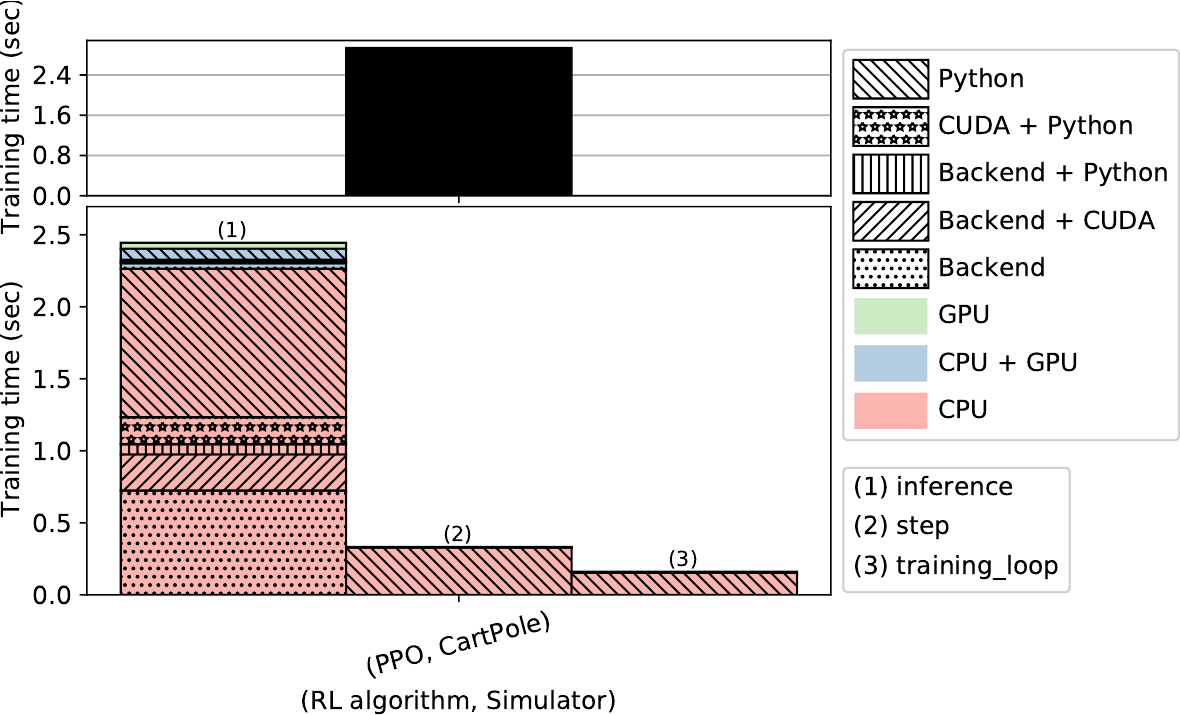

In [22]:
display_imgs('./rlscope_tutorial/*.operation_training_time.png')

This plot shows us the total training time broken down by operation, resource type (`CPU`, `GPU`), and fine-grained category (e.g., `CUDA`, `Backend`).  The vertical bars show us the operation names we added to our program (`training_loop`, `inference`, `step`).  Within each operation, stacked bars further break down the time into resource type, which are colour coded as 
$\color{lightgreen}{\text{GPU}}$,
$\color{lightblue}{\text{CPU + GPU}}$,
$\color{red}{\text{CPU}}$.

Within each resource type (colour), time is further divided into fine-grained categories (hatch pattern):
- **Backend** is CPU time spent in the C++ backend of the DL framework (PyTorch here).
- **CUDA** is CPU time spent executing CUDA API calls (e.g., `cudaLaunchKernel`, `cudaMemcpy`).
- **Python** is CPU time spent executing python code in the python interpretter.

2. **Transition plot:**

'./rlscope_tutorial/CategoryTransitionPlot.combined.png'

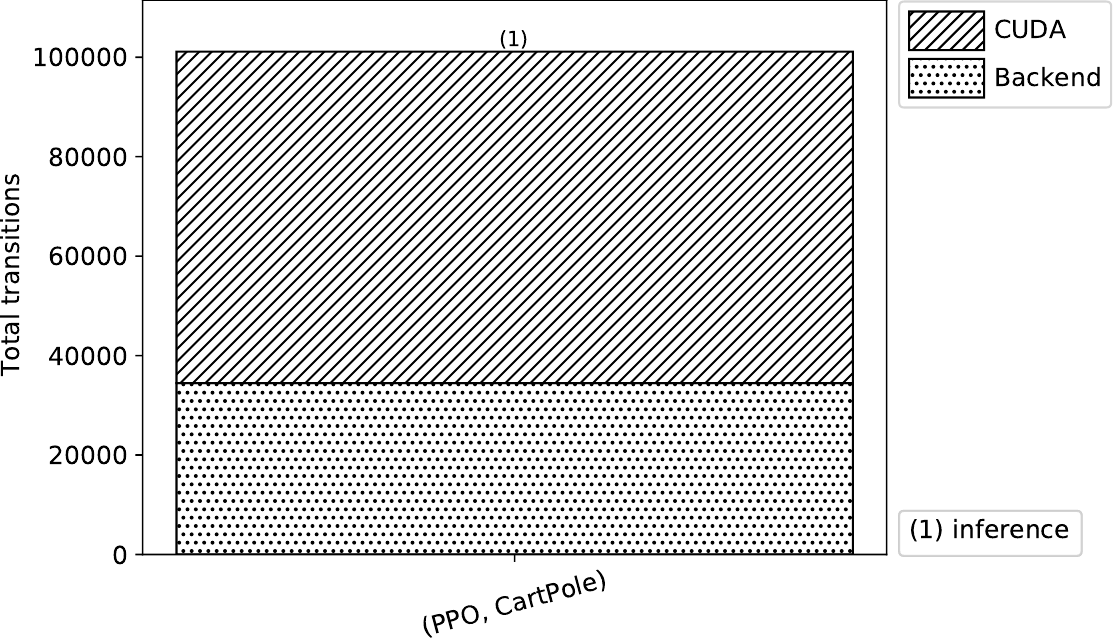

In [23]:
display_imgs('./rlscope_tutorial/CategoryTransitionPlot.combined.png')

This plot show the number of language transitions.  

- *Backend*: Python$\rightarrow$*Backend*

  Calls from Python into the C++ backend of the DL framework.

- *CUDA*: Backend$\rightarrow$*CUDA*

  CUDA API calls made by the framework.

A large number of language transitions can result in large times spent CPU-bound.  Eager execution suffers more from this compared to more optimized execution models (e.g., AutoGraph in TensorFlow, TorchScript in PyTorch, Graph in TensorFlow v1).

# Conclusion and next steps

In this notebook, we covered:
- How to install RL-Scope
- Basic RL-Scope API usage
- How to collect traces and generate plots using RL-Scope
- How to use the PyTorch based `stable-baselines3` RL framework to train a model
- How to write an evaluation inference loop in `stable-baselines3`

### Next steps

For simplicity, we only profiled the evaluation inference loop.  However, to profile RL algorithm training time, we will need to add RL-Scope annotations to the underlying RL framework.  This typically requires modifying the underlying RL framework so can profile portions of the training loop.

In a future tutorial (TODO) we will show how to modify the `stable-baselines3` framework to profile an RL training time.

# Resources / Links

For more information on the RL-Scope profiling tool:
- Installing RL-Scope: https://rl-scope.readthedocs.io/en/latest/installation.html
- Reproducing RL-Scope paper figures: https://rl-scope.readthedocs.io/en/latest/artifacts.html
- Developing/buildilng RL-Scope in a docker development environment: https://rl-scope.readthedocs.io/en/latest/host_config.html

For more information on the PyTorch based RL framework `stable-baselines3`:
- Jupyter notebook github: https://github.com/araffin/rl-tutorial-jnrr19/tree/sb3/
- `stable-baselines3` github: https://github.com/DLR-RM/stable-baselines3
- `stable-baselines3` documentation: https://stable-baselines3.readthedocs.io/en/master/
- RL Baselines3 zoo: https://github.com/DLR-RM/rl-baselines3-zoo
  
  RL Baselines3 Zoo is a collection of pre-tuned and pre-trained Reinforcement Learning agents using `stable-Baselines3`.